# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 144 rows (1 day), then skips 144 rows (1 day) before the next training window.

In [25]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = Path('.')
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 144    # 1 day of 10-minute samples
GAP = 0            # no skip between train and test blocks
MAX_TRAIN_ROWS = None  # use full history (no cap)
from xgboost import XGBRegressor






In [26]:
# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = DATA_DIR / "micro_climate_rh_t_et0.xlsx"

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Convert numeric columns
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Robust parse for micro timestamps (handles mixed formats)
micro_ts_raw = micro["timestamp_dayfirst"].astype(str).str.replace("‏", "", regex=False).str.strip()
micro_ts = micro_ts_raw.apply(lambda x: pd.to_datetime(x, dayfirst=True, errors="coerce"))
unparsed = micro_ts.isna().sum()
if unparsed:
    print(f"Warning: {unparsed} micro rows had unparsable timestamps; dropping them")
micro = micro.assign(timestamp=micro_ts).dropna(subset=["timestamp"])

# Ensure micro is sorted and truncated to the expected campaign window
micro = micro.sort_values("timestamp").reset_index(drop=True)
expected_start = pd.Timestamp("2025-05-29 01:00:00")
micro = micro[micro["timestamp"] >= expected_start].reset_index(drop=True)

# Parse weather/radiation timestamps
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()


(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [27]:
# Align all sources on timestamp; keep micro as spine
target_cols = ["internal_rh_pct"]
merged = micro.merge(weather, on="timestamp", how="left").merge(radiation, on="timestamp", how="left")

missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))

# Reindex to continuous 10-min grid; fill only exogenous columns
full_range = pd.date_range(micro["timestamp"].min(), micro["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()

exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()

# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")

# Optional manual outlier time windows (your list)
OUTLIER = [
    (pd.Timestamp("2025-09-11 06:00"), pd.Timestamp("2025-09-11 09:00")),
    (pd.Timestamp("2025-09-18 06:00"), pd.Timestamp("2025-09-18 09:00")),
    (pd.Timestamp("2025-08-27 08:00"), pd.Timestamp("2025-08-27 14:00")),
    (pd.Timestamp("2025-08-28 08:00"), pd.Timestamp("2025-08-28 11:00")),
]
if OUTLIER:
    before = len(data)
    for start, end in OUTLIER:
        data = data[(data["timestamp"] < start) | (data["timestamp"] > end)]
    removed = before - len(data)
    print(f"Removed {removed} rows based on OUTLIER")
    data = data.reset_index(drop=True)

# -------------------------
# Feature engineering (externals-only)
# -------------------------

# Calendar features
data["hour_of_day"] = data["timestamp"].dt.hour
data["day_of_year"] = data["timestamp"].dt.dayofyear

# Rolling medians to smooth noisy externals (6-step = 60 minutes)
smooth_cols = ["global_rad_wm2", "diffuse_rad_wm2", "direct_rad_wm2", "temp_c_ext", "rel_humidity_ext"]
for c in smooth_cols:
    if c in data.columns:
        data[f"{c}_med6"] = data[c].rolling(window=6, min_periods=1, center=True).median()

# External VPD + dew point
if {"temp_c_ext", "rel_humidity_ext"}.issubset(data.columns):
    data["vpd_ext_calc"] = calculate_vpd(data["temp_c_ext"], data["rel_humidity_ext"])
    data["dew_point_ext_calc"] = data["temp_c_ext"] - ((100 - data["rel_humidity_ext"]) / 5)

# Simple gradient proxy (fine to keep)
if {"dew_point_ext_calc", "temp_c_ext"}.issubset(data.columns):
    data["dewpoint_gradient"] = data["dew_point_ext_calc"] - data["temp_c_ext"]

# VPD rollups
if "vpd_ext_calc" in data.columns:
    data["vpd_ext_rolling_mean_30min"] = data["vpd_ext_calc"].rolling(window=3, min_periods=1).mean()
    data["vpd_ext_min_1h"] = data["vpd_ext_calc"].rolling(window=6, min_periods=1).min()

# Radiation integrals/peaks
if "global_rad_wm2" in data.columns:
    data["rad_integral_1h"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).sum()
    data["rad_peak_intensity"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).max()

# Extra sunrise dynamics
if "global_rad_wm2" in data.columns:
    data["rad_slope_10min"] = data["global_rad_wm2"].diff()
    data["rad_slope_30min"] = data["global_rad_wm2"].diff(3)
    data["rad_integral_3h"] = data["global_rad_wm2"].rolling(window=18, min_periods=1).sum()
    data["rad_peak_30min"] = data["global_rad_wm2"].rolling(window=3, min_periods=1).max()

# VPD dynamics + memory
if "vpd_ext_calc" in data.columns:
    data["vpd_slope_30min"] = data["vpd_ext_calc"].diff(3)
    data["vpd_integral_1h"] = data["vpd_ext_calc"].rolling(window=6, min_periods=1).sum()
    data["vpd_integral_1h_lag_1h"] = data["vpd_integral_1h"].shift(6)

# Ground temperature memory
if "temp_ground_c_ext" in data.columns:
    data["temp_ground_c_ext_lag_1h"] = data["temp_ground_c_ext"].shift(6)
    data["temp_ground_c_ext_lag_3h"] = data["temp_ground_c_ext"].shift(18)

# Cyclical time
hour = data["timestamp"].dt.hour + data["timestamp"].dt.minute / 60
data["hour_sin"] = np.sin(2*np.pi*hour/24)
data["hour_cos"] = np.cos(2*np.pi*hour/24)
doy = data["timestamp"].dt.dayofyear
data["doy_sin"] = np.sin(2*np.pi*doy/365.25)
data["doy_cos"] = np.cos(2*np.pi*doy/365.25)

# Build feature list: externals-only (hard exclude any internal or pred columns)
exclude_cols = ["internal_air_temp_c", "ET0", "internal_radiation"]  # internal vars you don't want
drop_cols = target_cols + ["timestamp", "timestamp_dayfirst", "date", "sunrise_ts"]

feature_cols = [c for c in data.columns if c not in drop_cols + exclude_cols]
feature_cols = [c for c in feature_cols if not c.startswith("pred_")]
feature_cols = [c for c in feature_cols if not c.startswith("internal_")]  # extra safety
feature_cols = [c for c in feature_cols if c != "ET0"]                     # extra safety


data.head()


diffuse_rad_wm2          0.929145
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 16,682
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00
Removed 94 rows based on OUTLIER


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,rad_peak_30min,vpd_slope_30min,vpd_integral_1h,vpd_integral_1h_lag_1h,temp_ground_c_ext_lag_1h,temp_ground_c_ext_lag_3h,hour_sin,hour_cos,doy_sin,doy_cos
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,0.0,NaN,0.764606,NaN,NaN,NaN,0.258819,0.965926,0.546711,-0.837321
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,0.0,NaN,1.524543,NaN,NaN,NaN,0.300706,0.953717,0.546711,-0.837321
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,0.0,NaN,2.279835,NaN,NaN,NaN,0.342020,0.939693,0.546711,-0.837321
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,0.0,0.036111,3.080552,NaN,NaN,NaN,0.382683,0.923880,0.546711,-0.837321
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,0.0,-0.013859,3.826629,NaN,NaN,NaN,0.422618,0.906308,0.546711,-0.837321


In [28]:
from sklearn.base import clone

rh_estimator = XGBRegressor(
    n_estimators=1500,
    max_depth=8,
    learning_rate=0.025,
    min_child_weight=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=2.0,
    reg_alpha=0.3,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",
    tree_method="hist",
)

def walk_forward(df, feature_cols, target_cols, model,
                 train_window=TRAIN_WINDOW, test_window=TEST_WINDOW,
                 gap=GAP, max_train_rows=MAX_TRAIN_ROWS):
    metrics = []
    preds = []
    train_end = train_window
    test_end = train_end + test_window
    run = 0

    while test_end <= len(df):
        train_start_idx = max(0, train_end - max_train_rows) if max_train_rows else 0
        train = df.iloc[train_start_idx:train_end]
        test = df.iloc[train_end:test_end]

        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }


        preds_run = {}

        for t_col in target_cols:
            model_t = clone(model)
            model_t.fit(train[feature_cols], train[t_col])
            pred_t = model_t.predict(test[feature_cols])

            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            mse = mean_squared_error(test[t_col], pred_t)
            metric[f"rmse_{t_col}"] = np.sqrt(mse)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)

        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )

        print(
            f"Run {run}: train {metric['train_rows']} rows ({metric['train_start']} -> {metric['train_end']}), "
            f"test {metric['test_rows']} rows ({metric['test_start']} -> {metric['test_end']})"
        )
        for t_col in target_cols:
            print(
                f"  {t_col}: MAE={metric[f'mae_{t_col}']:.4f}, "
                f"RMSE={metric[f'rmse_{t_col}']:.4f}, R2={metric[f'r2_{t_col}']:.4f}"
            )

        run += 1
        train_end += test_window
        test_end = train_end + test_window

    if not metrics:
        raise ValueError("Not enough data for a single walk-forward run; check window sizes.")

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)


In [29]:
metrics_rh, preds_rh = walk_forward(
    data,
    feature_cols,
    ["internal_rh_pct"],
    rh_estimator,
    max_train_rows=MAX_TRAIN_ROWS
)



display(metrics_rh)

summary = pd.DataFrame([{
    "variable": "internal_rh_pct",
    "mae": metrics_rh["mae_internal_rh_pct"].mean(),
    "rmse": metrics_rh["rmse_internal_rh_pct"].mean(),
    "r2": metrics_rh["r2_internal_rh_pct"].mean(),
}])
display(summary)

metrics_rh.to_csv("rh_metrics_one_stage.csv", index=False)
preds_rh.to_csv("rh_predictions_one_stage.csv", index=False)


Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_rh_pct: MAE=4.4857, RMSE=5.8178, R2=0.6727
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_rh_pct: MAE=2.0196, RMSE=2.7909, R2=0.9168
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_rh_pct: MAE=3.4779, RMSE=4.5977, R2=0.8430
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  internal_rh_pct: MAE=2.8188, RMSE=3.5566, R2=0.8729
Run 4: train 2016 rows (2025-05-29 01:00:00 -> 2025-06-12 00:50:00), test 144 rows (2025-06-12 01:00:00 -> 2025-06-13 00:50:00)
  internal_rh_pct: MAE=2.1165, RMSE=2.5529, R2=0.9400
Run 5: train 2160 rows (2025-05-29 01:00:00 -> 2025-06-13 00:50:00), test 144 rows (2025-0

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_rh_pct,rmse_internal_rh_pct,r2_internal_rh_pct
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,4.485673,5.817848,0.672748
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,2.019557,2.790912,0.916811
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,3.477918,4.597726,0.842998
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,2.818842,3.556606,0.872879
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,2.116476,2.552935,0.940032
...,...,...,...,...,...,...,...,...,...,...
100,100,2025-05-29 01:00:00,2025-09-16 15:10:00,2025-09-16 15:20:00,2025-09-17 15:10:00,15840,144,5.294028,6.814832,0.692683
101,101,2025-05-29 01:00:00,2025-09-17 15:10:00,2025-09-17 15:20:00,2025-09-18 18:20:00,15984,144,7.610572,9.029888,0.227267
102,102,2025-05-29 01:00:00,2025-09-18 18:20:00,2025-09-18 18:30:00,2025-09-19 18:20:00,16128,144,3.222184,4.233569,0.788244
103,103,2025-05-29 01:00:00,2025-09-19 18:20:00,2025-09-19 18:30:00,2025-09-20 18:20:00,16272,144,4.759742,6.580216,0.534180


,variable,mae,rmse,r2
0,internal_rh_pct,2.592799,3.376607,0.861071


In [30]:
# ---- Worst runs table + test-window sanity checks ----
m = metrics_rh.copy()

# duration in hours (should be ~24 if your folds are truly 1 day)
m["test_duration_hours"] = (m["test_end"] - m["test_start"]).dt.total_seconds() / 3600

# show worst 15 runs (lowest R2)
worst = m.sort_values("r2_internal_rh_pct").head(15)[
    ["run", "test_start", "test_end", "test_duration_hours",
     "mae_internal_rh_pct", "rmse_internal_rh_pct", "r2_internal_rh_pct"]
]
display(worst)

print("Test window duration stats (hours):")
display(m["test_duration_hours"].describe())

# quick flag: anything far from 24 hours is NOT a clean "next day" evaluation
display(m.loc[(m["test_duration_hours"] < 23) | (m["test_duration_hours"] > 25),
              ["run","test_start","test_end","test_duration_hours","r2_internal_rh_pct"]]
        .sort_values("test_duration_hours"))


,run,test_start,test_end,test_duration_hours,mae_internal_rh_pct,rmse_internal_rh_pct,r2_internal_rh_pct
101,101,2025-09-17 15:20:00,2025-09-18 18:20:00,27.000000,7.610572,9.029888,0.227267
65,65,2025-08-12 02:50:00,2025-08-13 02:40:00,23.833333,7.454375,9.197618,0.248386
94,94,2025-09-10 12:10:00,2025-09-11 15:10:00,27.000000,4.319630,6.349905,0.388737
95,95,2025-09-11 15:20:00,2025-09-12 15:10:00,23.833333,8.240471,10.452768,0.445809
103,103,2025-09-19 18:30:00,2025-09-20 18:20:00,23.833333,4.759742,6.580216,0.534180
63,63,2025-08-10 02:50:00,2025-08-11 02:40:00,23.833333,6.263180,9.342989,0.548097
80,80,2025-08-27 02:50:00,2025-08-28 12:00:00,33.166667,3.768035,4.471804,0.548655
81,81,2025-08-28 12:10:00,2025-08-29 12:00:00,23.833333,3.268856,4.325569,0.583569
99,99,2025-09-15 15:20:00,2025-09-16 15:10:00,23.833333,4.612759,6.372442,0.635291
70,70,2025-08-17 02:50:00,2025-08-18 02:40:00,23.833333,5.081375,6.071950,0.669506


Test window duration stats (hours):


count    105.000000
mean      24.000000
std        1.008246
min       23.833333
25%       23.833333
50%       23.833333
75%       23.833333
max       33.166667
Name: test_duration_hours, dtype: float64

,run,test_start,test_end,test_duration_hours,r2_internal_rh_pct
94,94,2025-09-10 12:10:00,2025-09-11 15:10:00,27.000000,0.388737
101,101,2025-09-17 15:20:00,2025-09-18 18:20:00,27.000000,0.227267
80,80,2025-08-27 02:50:00,2025-08-28 12:00:00,33.166667,0.548655


In [31]:
import matplotlib.pyplot as plt

def plot_run(run_id, df=data, preds_df=preds_rh,
             ext_rh_col="rel_humidity_ext",
             ext_temp_col="temp_c_ext",
             rad_col="global_rad_wm2"):
    sub = preds_df[preds_df["run"] == run_id].copy()
    if sub.empty:
        print(f"Run {run_id}: no predictions found")
        return

    # merge externals for same timestamps (from your aligned 'data')
    cols = ["timestamp"]
    for c in [ext_rh_col, ext_temp_col, rad_col]:
        if c in df.columns:
            cols.append(c)
    ex = df[cols].copy()

    merged = sub.merge(ex, on="timestamp", how="left").sort_values("timestamp")

    # Metrics line
    row = metrics_rh.loc[metrics_rh["run"] == run_id].iloc[0]
    title = (f"Run {run_id} | R2={row['r2_internal_rh_pct']:.3f} "
             f"MAE={row['mae_internal_rh_pct']:.3f} "
             f"{row['test_start']} -> {row['test_end']}")

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # RH (left axis)
    ax1.plot(merged["timestamp"], merged["internal_rh_pct"], label="Internal RH actual")
    ax1.plot(merged["timestamp"], merged["pred_internal_rh_pct"], label="Internal RH pred", alpha=0.85)
    if ext_rh_col in merged.columns:
        ax1.plot(merged["timestamp"], merged[ext_rh_col], label="External RH", linestyle="--", alpha=0.7)
    ax1.set_ylabel("RH (%)")
    ax1.set_title(title)
    ax1.legend(loc="upper left")

    # Radiation (right axis #1)
    ax2 = ax1.twinx()
    if rad_col in merged.columns:
        ax2.plot(merged["timestamp"], merged[rad_col], label="Global Rad", linestyle=":", alpha=0.7)
        ax2.set_ylabel("Radiation (W/m²)")

    # Temp (right axis #2, offset)
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.08))
    if ext_temp_col in merged.columns:
        ax3.plot(merged["timestamp"], merged[ext_temp_col], label="External Temp", linestyle="-.", alpha=0.7)
        ax3.set_ylabel("Temp (°C)")

    # combined legend (ax2/ax3)
    lines, labels = ax1.get_legend_handles_labels()
    for ax in [ax2, ax3]:
        l2, lab2 = ax.get_legend_handles_labels()
        lines += l2
        labels += lab2
    ax1.legend(lines, labels, loc="upper right")

    plt.tight_layout()
    plt.show()


In [33]:
df = data.copy().sort_values("timestamp").reset_index(drop=True)

# 10-min deltas
df["rh_delta_10m"] = df["internal_rh_pct"].diff()
if "rel_humidity_ext" in df.columns:
    df["ext_rh_delta_10m"] = df["rel_humidity_ext"].diff()

# Basic "impossible/very unlikely" sensor jump flag (tune threshold after you inspect histogram)
RH_JUMP = 12  # %RH per 10 minutes (start here; tune)
df["flag_rh_jump"] = df["rh_delta_10m"].abs() >= RH_JUMP

# Mismatch vs external RH movement: internal jumps hard while external barely moves
if "ext_rh_delta_10m" in df.columns:
    df["flag_rh_mismatch"] = (df["rh_delta_10m"].abs() >= RH_JUMP) & (df["ext_rh_delta_10m"].abs() <= 2)

# Sunrise-related: big radiation increase + RH drop (could be real, not an outlier)
if "global_rad_wm2" in df.columns:
    df["rad_delta_10m"] = df["global_rad_wm2"].diff()
    df["flag_sunrise_drop"] = (df["rad_delta_10m"] >= 50) & (df["rh_delta_10m"] <= -RH_JUMP)

# Show suspicious rows
cols_show = ["timestamp","internal_rh_pct","rh_delta_10m"]
for c in ["rel_humidity_ext","ext_rh_delta_10m","global_rad_wm2","rad_delta_10m",
          "flag_rh_jump","flag_rh_mismatch","flag_sunrise_drop"]:
    if c in df.columns:
        cols_show.append(c)

sus = df[df.get("flag_rh_jump", False) | df.get("flag_rh_mismatch", False)].copy()
display(sus[cols_show].head(50))
print("Total flagged rows:", len(sus))


,timestamp,internal_rh_pct,rh_delta_10m,rel_humidity_ext,ext_rh_delta_10m,global_rad_wm2,rad_delta_10m,flag_rh_jump,flag_rh_mismatch,flag_sunrise_drop
5,2025-05-29 01:50:00,84.311250,12.334610,73.0,3.0,0.0,0.0,True,False,False
42,2025-05-29 08:00:00,66.784600,-12.586320,69.0,-1.0,404.0,32.0,True,True,False
284,2025-05-31 00:20:00,94.789120,13.646534,71.0,2.0,0.0,0.0,True,True,False
321,2025-05-31 06:30:00,85.482360,-14.175610,77.0,-2.0,78.0,37.0,True,True,False
331,2025-05-31 08:10:00,66.875725,-16.030575,32.0,-4.0,436.0,33.0,True,False,False
1772,2025-06-10 08:20:00,63.015980,-14.293350,69.0,-1.0,473.0,106.0,True,True,True
2170,2025-06-13 02:40:00,60.160908,-12.898052,88.0,0.0,2.0,1.0,True,True,False
2171,2025-06-13 02:50:00,77.281420,17.120512,89.0,1.0,1.0,-1.0,True,True,False
2779,2025-06-17 08:20:00,57.733200,-12.144820,63.0,-2.0,367.0,-31.0,True,True,False
2908,2025-06-18 05:50:00,64.998344,-14.356526,89.0,0.0,11.0,11.0,True,True,False


Total flagged rows: 27


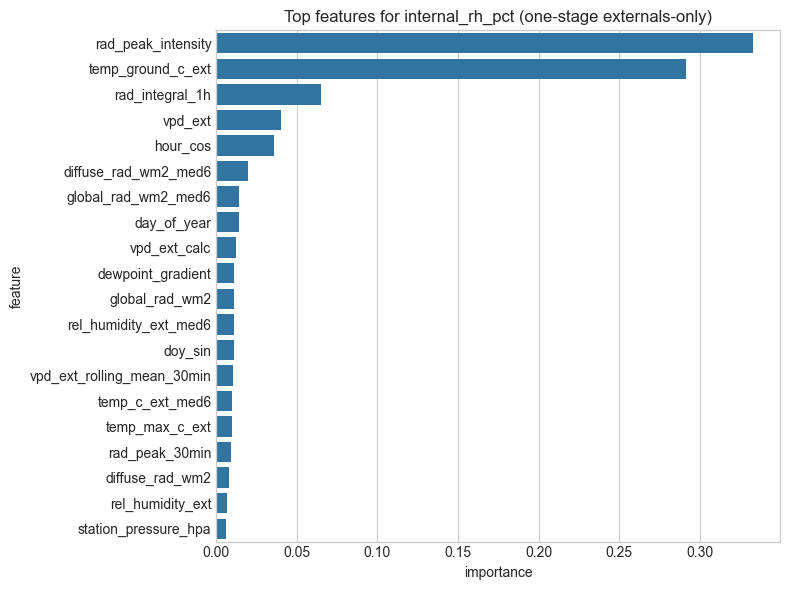

,feature,importance
32,rad_peak_intensity,0.333234
5,temp_ground_c_ext,0.291345
31,rad_integral_1h,0.064803
13,vpd_ext,0.039925
43,hour_cos,0.035793
22,diffuse_rad_wm2_med6,0.019673
21,global_rad_wm2_med6,0.014337
20,day_of_year,0.014171
26,vpd_ext_calc,0.012419
28,dewpoint_gradient,0.011168


In [34]:
model_full = clone(rh_estimator)
model_full.fit(data[feature_cols], data["internal_rh_pct"])

fi = model_full.feature_importances_
importance_df = pd.DataFrame({"feature": feature_cols, "importance": fi}).sort_values("importance", ascending=False)

top20 = importance_df.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=top20)
plt.title("Top features for internal_rh_pct (one-stage externals-only)")
plt.tight_layout()
plt.show()

display(top20)


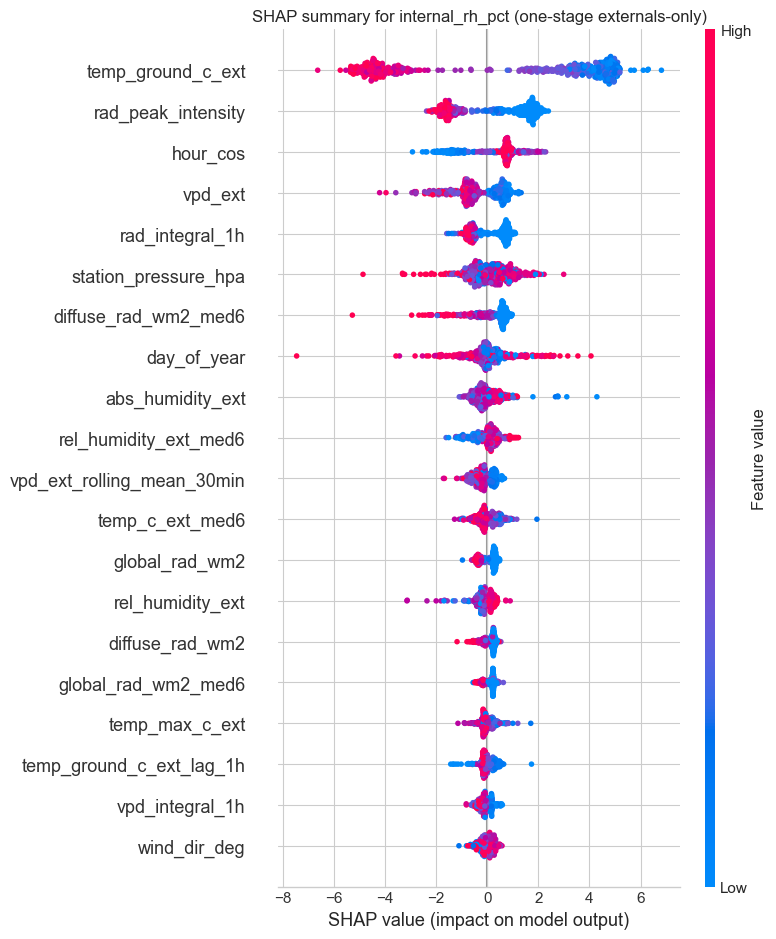

In [35]:
import shap
shap.initjs()

rh_model = clone(rh_estimator)
rh_model.fit(data[feature_cols], data["internal_rh_pct"])

sample_n = min(500, len(data))
shap_sample = data.sample(sample_n, random_state=42)

explainer = shap.TreeExplainer(rh_model)
shap_values = explainer.shap_values(shap_sample[feature_cols])

shap.summary_plot(shap_values, shap_sample[feature_cols], show=False)
plt.title("SHAP summary for internal_rh_pct (one-stage externals-only)")
plt.tight_layout()
plt.show()


Found 16 low-R2 runs: [0, 63, 65, 69, 70, 78, 80, 81, 83, 94, 95, 98, 99, 100, 101, 103]


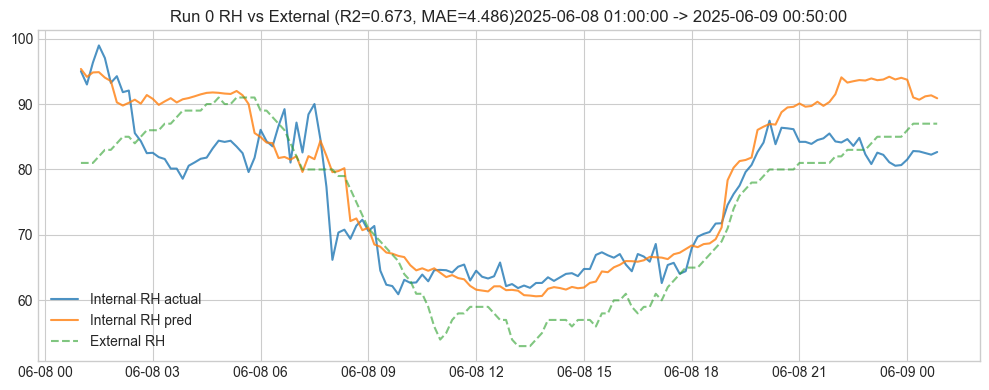

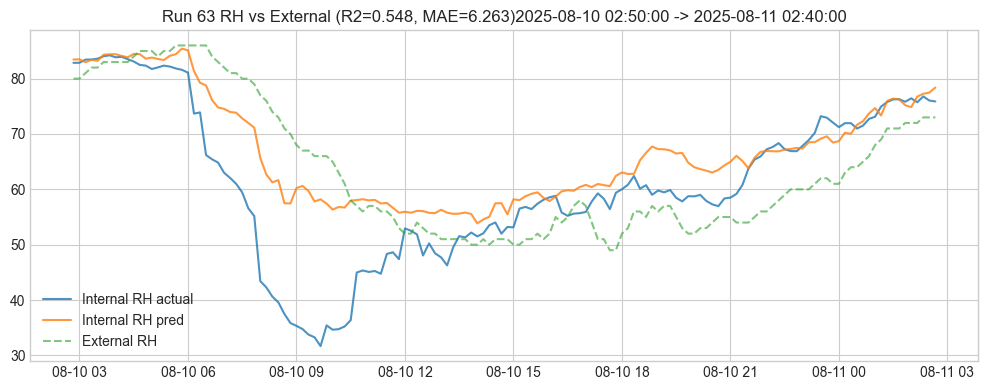

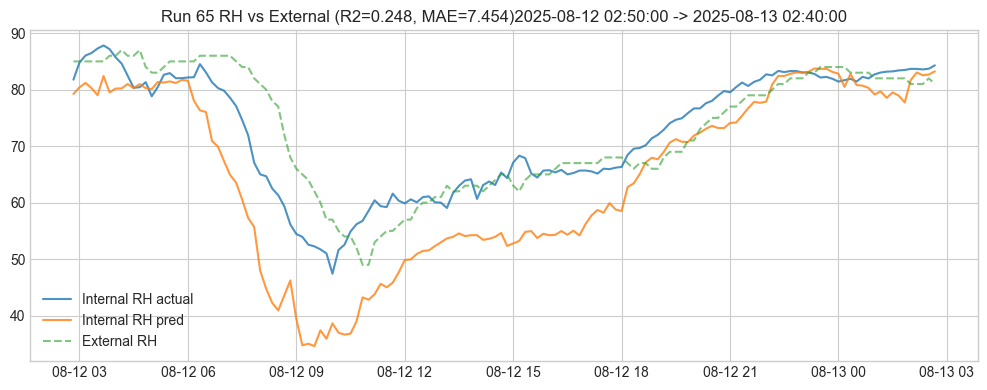

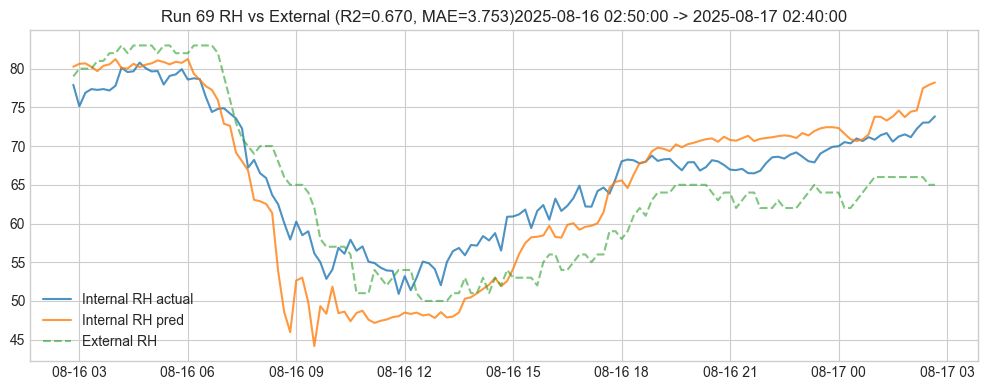

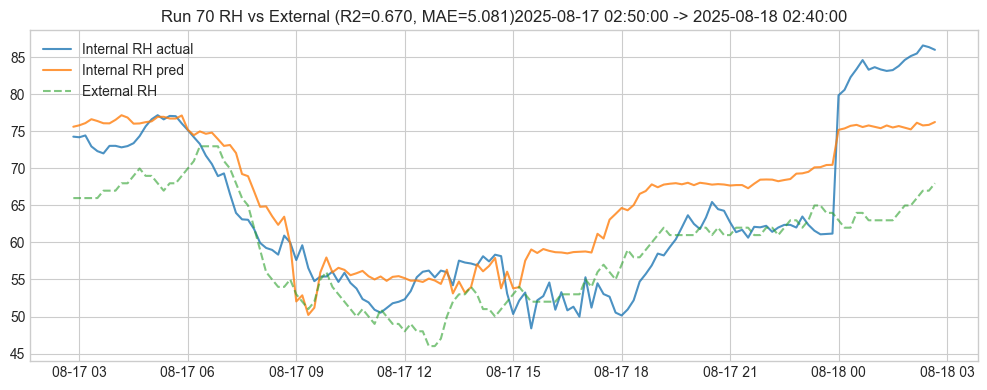

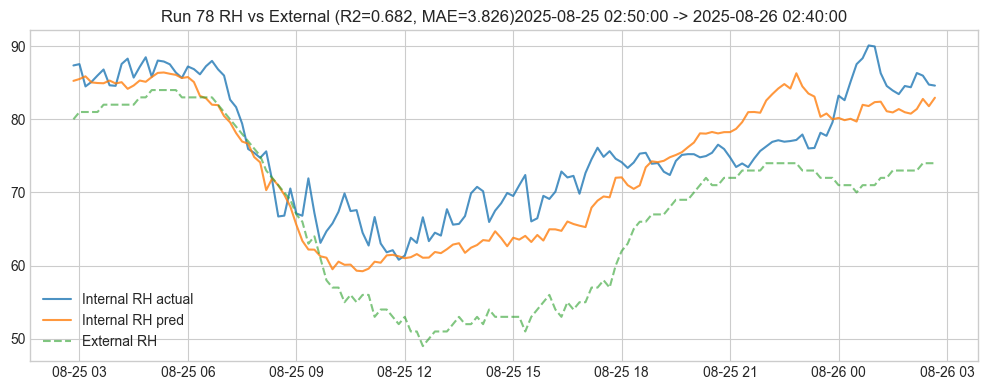

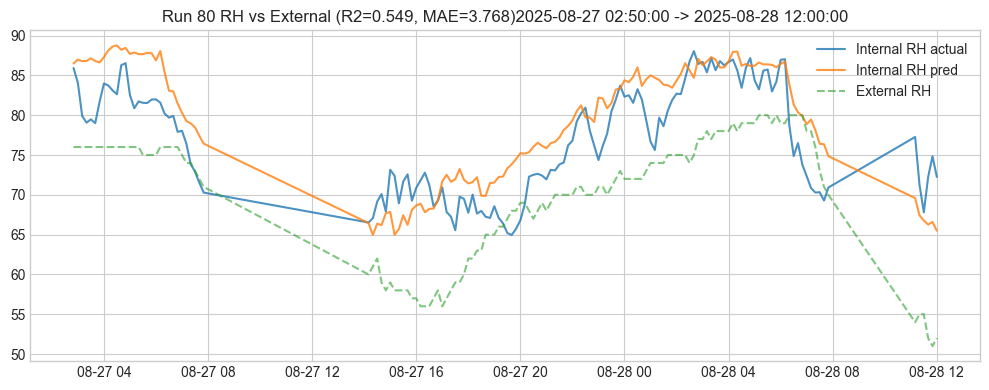

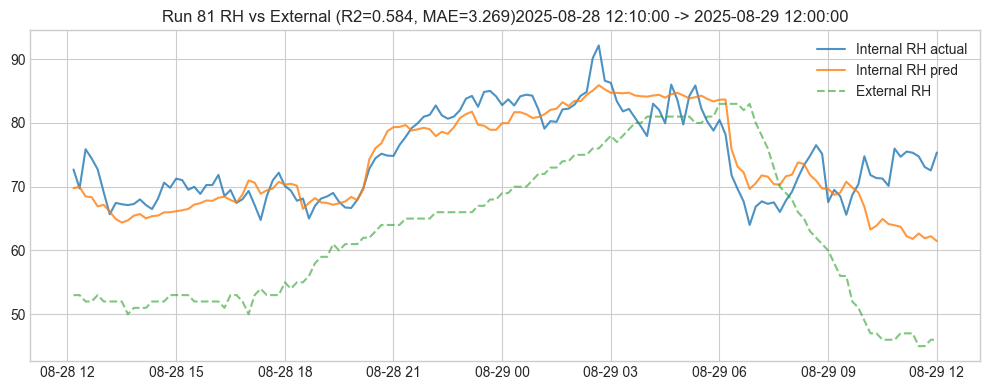

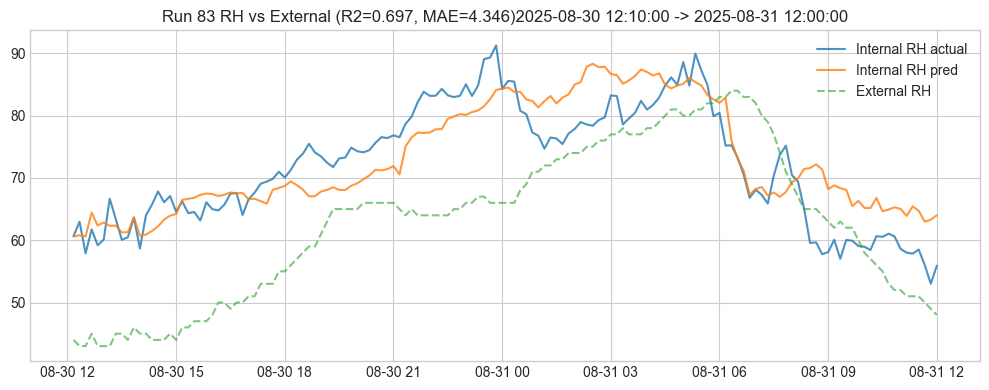

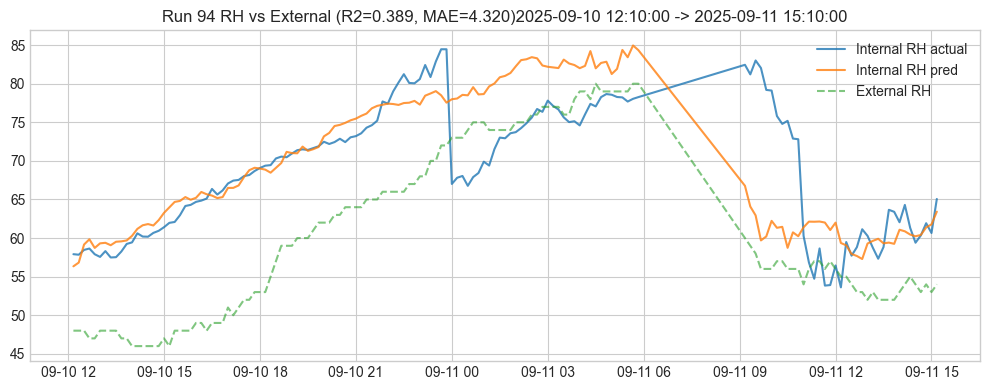

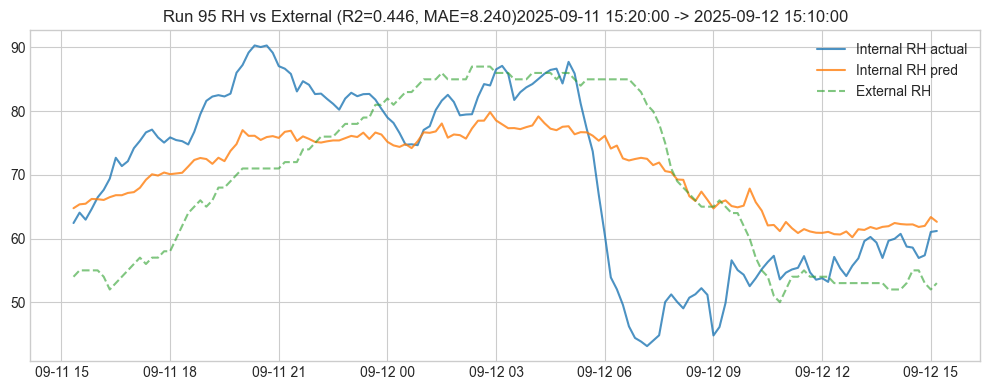

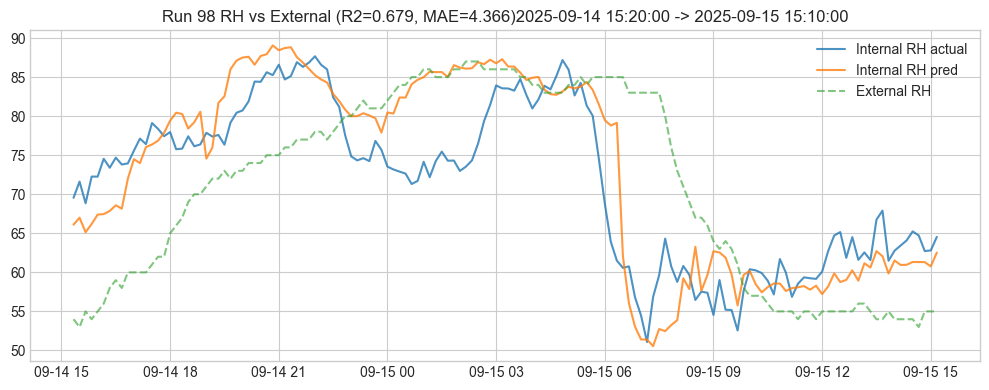

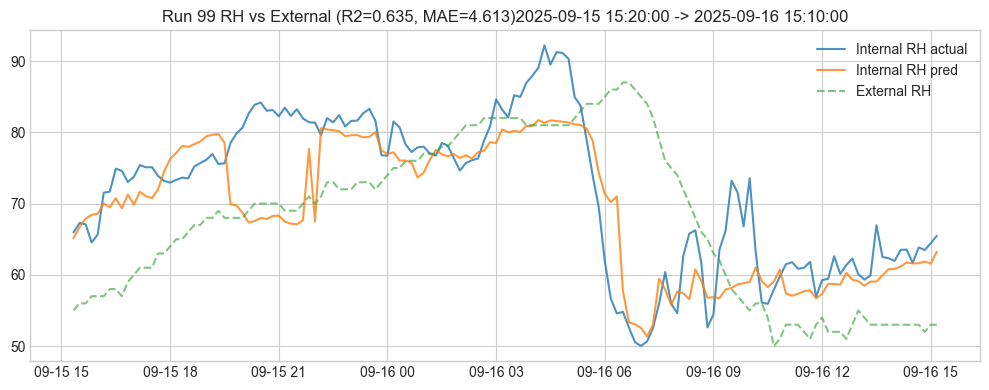

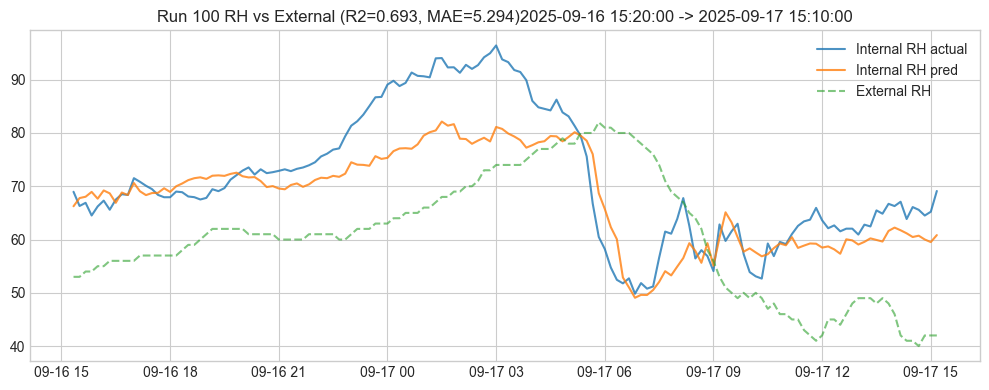

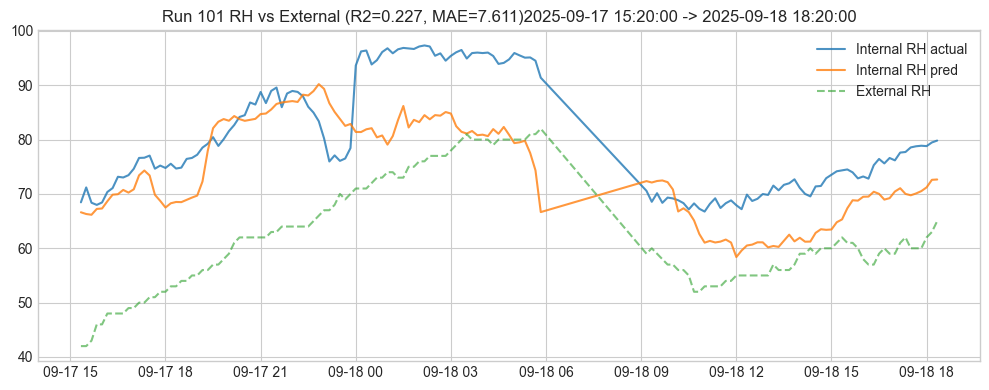

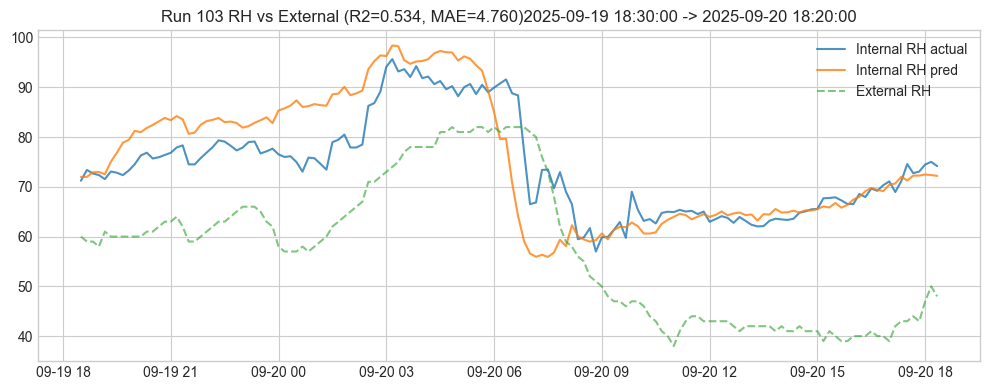

In [36]:
# Plot internal RH vs external RH for runs with low R2 (<0.7)
# metrics_df/preds_df come from stage-2 RH walk-forward
metrics_df = metrics_rh
preds_df = preds_rh
bad_runs = metrics_df[metrics_df.get('r2_internal_rh_pct', 1) < 0.7]
if bad_runs.empty:
    print('No runs with r2_internal_rh_pct < 0.7')
else:
    print(f"Found {len(bad_runs)} low-R2 runs: {bad_runs['run'].tolist()}")
    for _, row in bad_runs.iterrows():
        r = int(row['run'])
        test_start = row['test_start']
        test_end = row['test_end']
        # actual/pred from preds_df
        sub_pred = preds_df[preds_df['run'] == r]
        # external RH from original data in the test window
        ext_slice = data[(data['timestamp'] >= test_start) & (data['timestamp'] <= test_end)][['timestamp', 'rel_humidity_ext']]
        if sub_pred.empty or ext_slice.empty:
            print(f'Run {r}: missing data; skipping')
            continue
        merged = sub_pred.merge(ext_slice, on='timestamp', how='left')
        plt.figure(figsize=(10, 4))
        plt.plot(merged['timestamp'], merged['internal_rh_pct'], label='Internal RH actual', alpha=0.8)
        if 'pred_internal_rh_pct' in merged.columns:
            plt.plot(merged['timestamp'], merged['pred_internal_rh_pct'], label='Internal RH pred', alpha=0.8)
        plt.plot(merged['timestamp'], merged['rel_humidity_ext'], label='External RH', alpha=0.6, linestyle='--')
        if 'global_rad_wm2' in merged.columns:
            plt.plot(merged['timestamp'], merged['global_rad_wm2'], label='External Global Rad', alpha=0.5, linestyle=':')
        plt.title(f"Run {r} RH vs External (R2={row['r2_internal_rh_pct']:.3f}, MAE={row['mae_internal_rh_pct']:.3f}){test_start} -> {test_end}")
        plt.legend()
        plt.tight_layout()
        plt.show()
